### Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython import display

Loading word2vec model, getting its keyword vectors

In [3]:
import gensim.downloader as api
from gensim.models import KeyedVectors
model_name = 'word2vec-google-news-300'
wv: KeyedVectors = api.load(model_name)

Loading dataset into pandas dataframe.

Score column represents how man times annotators considered this pair of two words **more similar** that another word pair of two words. Each annotator was given two words pairs 50 times, where he had to choose a pair of words, where two words are more similar to each other then in another pair. 

In [4]:
import pandas as pd

men_dataset_path = "../../datasets/MEN/MEN_dataset_natural_form_full"

# Read the data into a pandas DataFrame
df = pd.read_csv(
    men_dataset_path, sep=" ", header=None, names=["word1", "word2", "score"]
)

# Display the first 10 rows
df.head(10)

,word1,word2,score
0,sun,sunlight,50.0
1,automobile,car,50.0
2,river,water,49.0
3,stairs,staircase,49.0
4,morning,sunrise,49.0
5,rain,storm,49.0
6,cat,kittens,49.0
7,dance,dancers,49.0
8,camera,photography,49.0
9,cat,feline,48.0


The score is not absolute value, it is relative to another pair. That is we such word pairs like angel-gasoline were chosen by some annotator, because the annotator probably could have choose between, for example, angel-gasoline and bakery-zebra words pairs.

In [5]:
df.tail(10)

,word1,word2,score
2990,posted,tulip,2.0
2991,grave,hat,2.0
2992,apple,cute,2.0
2993,angel,gasoline,1.0
2994,giraffe,harbor,1.0
2995,feathers,truck,1.0
2996,festival,whiskers,1.0
2997,muscle,tulip,1.0
2998,bikini,pizza,1.0
2999,bakery,zebra,0.0


### Normalization of scores and shuffling

Normalizing score column to be a value from 0 to 1

Also, let's shuffle data

In [6]:
df["score"] = df["score"] / 50
df = df.sample(frac=1, random_state=42)
df.head(10)

,word1,word2,score
1801,jean,washing,0.42
1190,blurred,lens,0.60
1817,lunch,morning,0.42
251,daffodils,plant,0.84
2505,animals,sandwich,0.22
1117,bathroom,floor,0.62
1411,birds,wild,0.54
2113,animals,clown,0.32
408,cafe,lunch,0.80
2579,friends,rusty,0.20


### Computing similarity scores using word2vec model

In [7]:
import numpy as np


def similarity(word1: str, word2: str, model: KeyedVectors) -> float | None:
    if word1 not in model or word2 not in model:
        return None
    return np.dot(wv[word1], wv[word2])


print(
    f"cat x dog: cos_sim: {wv.similarity('cat', 'dog')}; dot_sim: {np.dot(wv['cat'],wv['dog'])}"
)
print(
    f"kitty x dog: cos_sim: {wv.similarity('kitty', 'dog')}; dot_sim: {np.dot(wv['kitty'],wv['dog'])}"
)

df["similarity"] = df.apply(
    lambda row: similarity(row["word1"], row["word2"], model=wv), axis=1
)

df.head(10)

cat x dog: cos_sim: 0.760945737361908; dot_sim: 6.890859603881836
kitty x dog: cos_sim: 0.41645821928977966; dot_sim: 3.648754119873047


,word1,word2,score,similarity
1801,jean,washing,0.42,0.891527
1190,blurred,lens,0.60,3.109732
1817,lunch,morning,0.42,2.400035
251,daffodils,plant,0.84,2.035933
2505,animals,sandwich,0.22,0.172007
1117,bathroom,floor,0.62,3.046194
1411,birds,wild,0.54,3.066041
2113,animals,clown,0.32,1.924758
408,cafe,lunch,0.80,3.298803
2579,friends,rusty,0.20,0.320767


### OOV statistics

In [8]:
OOV_pairs = df[df['similarity'].isnull()]
OOV_pairs.head(10)

,word1,word2,score,similarity
314,beach,harbour,0.82,NaN
2377,theatre,wolf,0.24,NaN
1321,harbour,town,0.56,NaN
486,blue,grey,0.78,NaN
433,bright,colour,0.78,NaN
1105,dark,grey,0.62,NaN
2627,held,theatre,0.18,NaN
170,colour,pink,0.86,NaN
831,black,colour,0.70,NaN
1413,cliff,harbour,0.54,NaN


In [9]:
total_rows_number = df.shape[0]
print(f"Total rows number: {total_rows_number}")

oov_rows_number = OOV_pairs.shape[0]
print(f"Total OOV rows number: {oov_rows_number}")

ratio = oov_rows_number/total_rows_number
print(f"Ratio: {ratio}")

Total rows number: 3000
Total OOV rows number: 54
Ratio: 0.018


### Normalizing similarity scores using linear transformations and linear scaling

Problem is that normalized score's range is [0.0, 1.0], when similarity function range is bound to cosine range [-1.0, 1.0]

Thus, we can see negative similiarity scores:

In [10]:
similarity = df['similarity']
min_value = similarity.min()
max_value = similarity.max()
print(f"Max: {max_value}",f"Min: {min_value}")

Max: 10.436864852905273 Min: -0.8207118511199951


### Binary classification using thresholds

In [11]:
# Filter out rows with 'None' similarity
df_filtered = df[df["similarity"].notnull()].copy()

In [15]:
actual_class_threshold = 0.5
df_filtered["actual_class"] = df_filtered["score"] > actual_class_threshold

df_filtered.head(10)

,word1,word2,score,similarity,actual_class,predicted_class
1801,jean,washing,0.42,0.891527,False,True
1190,blurred,lens,0.60,3.109732,True,True
1817,lunch,morning,0.42,2.400035,False,True
251,daffodils,plant,0.84,2.035933,True,True
2505,animals,sandwich,0.22,0.172007,False,False
1117,bathroom,floor,0.62,3.046194,True,True
1411,birds,wild,0.54,3.066041,True,True
2113,animals,clown,0.32,1.924758,False,True
408,cafe,lunch,0.80,3.298803,True,True
2579,friends,rusty,0.20,0.320767,False,False


### Statistics

Now let's use binary classification statistics:

In [20]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve

y_true = np.where(df_filtered["actual_class"], 1, 0)
y_similarity_scores = df_filtered['similarity'].to_numpy()
precision, recall, thresholds = precision_recall_curve(y_true, y_similarity_scores)

print(thresholds)

[-0.82071185 -0.77351981 -0.71040988 ... 10.20827198 10.24261284
 10.43686485]


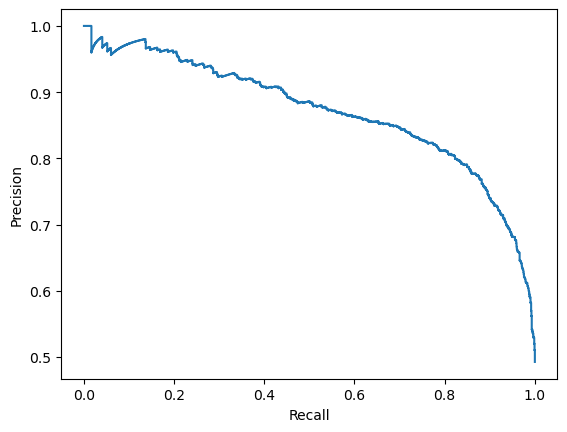

In [21]:
from sklearn.metrics import PrecisionRecallDisplay
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)
pr_display.plot()